In [26]:
## Streamflow analysis using baseflow seperation and flow duration curves

# This code is based on:
# https://www.lawrencesekaluvu.com/hydrologic-models-tools/hydrologic-tools/usgs-streamflow 

In [27]:
# Import required packages

import hydrofunctions as hf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

In [28]:
# A function that downloads the daily streamflow data from the USGS database

def streamflow_raw (station_id,start_date, end_date):
    # Extract streamflow from a gauge
    flow_extract = hf.NWIS(str(station_id), 'dv', start_date, end_date, parameterCd='00060')
    # Convert the data object to a data frame
    raw_flow = flow_extract.get_data().df().reset_index()
    # Add names to the data frame
    raw_flow.columns = ['Date', 'Flow (cfs)', 'Code']
    # set date as index
    raw_flow.index = pd.to_datetime(raw_flow.Date)
    # Exclude negative flow values if they exist and replace any negative values with nan if any
    raw_flow.loc[raw_flow['Flow (cfs)']<0,'Flow (cfs)'] = np.nan
    # Make sure that the dates are consistent
    raw_flow_daily = raw_flow [['Flow (cfs)', 'Code']].resample('D').asfreq()
    return (raw_flow_daily.round(2))

In [41]:
# Pick the gauge and timperiod of interest.
# You can select a streamflow gauge using:
# https://maps.waterdata.usgs.gov/mapper/index.html
# Note that catchemnts may having missing data

'''
A function streamflow_raw that extracts USGS streamflow data
Inputs: 
    station_id -  USGS station Id
    start_date - Start date
    end_date  - End date
Outputs:
    Daily streamflow records
'''

station_id = '07374000'  #'03336000' 
start_date = '2015-10-01'
end_date   = '2020-10-19'


# Extract streamflow data using streamflow_raw function
raw_flow = streamflow_raw (station_id,start_date, end_date)

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07374000&parameterCd=00060&startDT=2015-10-01&endDT=2020-10-19


/Users/wbs211/opt/anaconda3/lib/python3.9/site-packages/hydrofunctions/station.py:311: FutureWarning: It is no longer necessary to call .get_data() to request data.
  warnings.warn(


In [42]:
# A baseflow seperation filer based on Lyne & Hollick (1979)

"""
A function Lyne_Hollick that  performs baseflow separation based on Lyne and Hollick, 1979.
Q: Time series of streamflow measurements
alpha : filter parameter
direction : Options - forward (f) or backward (b) calculation
"""



def Lyne_Hollick(Q,bflow, alpha=.925, direction = 'f'):
    # Check if there has already been a run
    if len(bflow) > 0:
        Q = np.array(bflow)
    else:
        Q = np.array(Q)
    f = np.zeros(len(Q))
    if direction[0] == 'f':
        for t in np.arange(1,len(Q)):
            # algorithm
            f[t] = alpha * f[t-1] + (1 + alpha)/2 * (Q[t] - Q[t-1])
            # to prevent negative values
            if Q[t] - f[t] > Q[t]:
                f[t] = 0
    elif direction[0] == 'b':
        for t in np.arange(len(Q)-2, 1, -1):
            f[t] = alpha * f[t+1] + (1 + alpha)/2 * (Q[t] - Q[t+1])
            if Q[t] - f[t] > Q[t]:
                f[t] = 0

    return (f)


"""
A function Eckhardt that separates streamflow into baseflow and stormflow. 
The recursive digital filter for baseflow separation developed Based on Eckhardt (2004)
Inputs:
Qt: Time series of streamflow measurements
alpha : filter parameter
BFI : maximum baseflow index
re : number of times to run filter
"""
def Eckhardt(Qt,alpha, BFI, re):
    bflow = []
    # Check if bflow is empty - useful in handling multiple filtering
    if len(bflow) > 0:
        Qt = np.array(bflow)
    else:
        Qt = np.array(Qt)
    # Create an array of zeros - used to collect basefloe values
    f = np.zeros(len(Qt))
    
    # Initialize baseflow at time, t = 0 
    f[0] = Qt[0]
    # Filter out baseflow from streamflow
    for t in np.arange(1,len(Qt)):
        # algorithm
        f[t] = ((1 - BFI) * alpha * f[t-1] + (1 - alpha) * BFI * Qt[t]) / (1 - alpha * BFI)
        if f[t] > Qt[t]:
            f[t] = Qt[t]
            
    # Adds the baseflow to self variables so it can be called recursively
    bflow = f
    # calls method again if multiple passes are specified
    if re > 1:
        bflow = Eckhardt(Qt,bflow,alpha=alpha, BFI=BFI, re=re-1)
    
    return (bflow)

In [43]:
# Parameters for Eckhardt function
q = raw_flow['Flow (cfs)']
alpha = 0.95
re = 1
bfi = 0.7

# Running the Eckhardt algorithm
baseflow = Eckhardt(q,alpha, bfi, re)

# Add base flow to the streamflow data frame
raw_flow['baseflow'] = baseflow
# Compute runoff
raw_flow['runoff'] = q-baseflow

In [44]:
# Running the Lyne_Hollick algorithm
bflow = []
stormflow = Lyne_Hollick(q, bflow, .975, direction = 'f')
# Add base flow to the streamflow data frame
raw_flow['baseflow'] = q-stormflow
# Compute runoff
raw_flow['runoff'] = stormflow

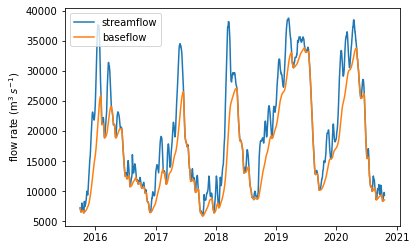

In [45]:
## Plot the Hydrograph
plt.plot(0.0283168466*raw_flow['Flow (cfs)'])
plt.plot(0.0283168466*raw_flow['baseflow'])
plt.ylabel('flow rate (m$^3$ $s^{-1}$)')
plt.legend(['streamflow','baseflow'])


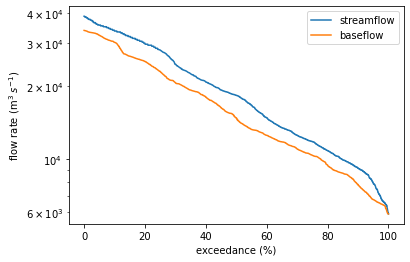

In [46]:
## Plot the Flow Duration Curve

Q_FDC = raw_flow.sort_values(by=['Flow (cfs)'])
Q_FDC1 = np.array(Q_FDC['Flow (cfs)'])
Q_FDC = raw_flow.sort_values(by=['baseflow'])
Q_FDC2 = np.array(Q_FDC['baseflow'])
x = np.linspace(100,0,len(Q_FDC2))
plt.plot(x,0.0283168466*Q_FDC1)
plt.plot(x,0.0283168466*Q_FDC2)
plt.yscale('log')
plt.ylabel('flow rate (m$^3$ $s^{-1}$)')
plt.xlabel('exceedance (%)')
plt.legend(['streamflow','baseflow'])

In [ ]:
## Exercise 

